In [63]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split

import PIL
from PIL import Image
from PIL import ImageOps

import fastai
from fastai.vision.all import *

import cv2

In [64]:
import os 
print("Input folder contains: " + str(os.listdir("input")))
print()

path_train_str = "input/train"

path_train = os.listdir("input/train")
path_test = os.listdir("input/test")

path_train_count = len([name for name in path_train])
path_test_count = len([name for name in path_test])

print("The number of pictures in train folder: " + f"{path_train_count:,}")
print("The number of pictures in test folder: " + f"{path_test_count:,}")




Input folder contains: ['.DS_Store', 'test', 'airbus-ship-detection', 'sample_submission_v2.csv', 'train', 'train_ship_segmentations_v2.csv']

The number of pictures in train folder: 192,556
The number of pictures in test folder: 15,607


## Open train image

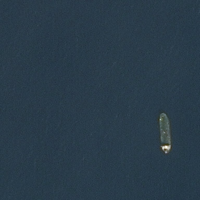

In [65]:
first_image = str(path_train[220])
PIL.Image.open("input/train/" + first_image).resize((200, 200))

In [66]:
# Import the dataframe with segmentation data which represents the masks
df_segm = pd.read_csv("input/train_ship_segmentations_v2.csv").dropna()
df_segm = df_segm.set_index('ImageId')
print(df_segm.head())

train_ids = df_segm.index.values # Get all the image IDs


                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         EncodedPixels
ImageId                                                                                                                                                                                                                                                                                                                                                                                          

Text(0.5, 1.0, 'Training dataset')

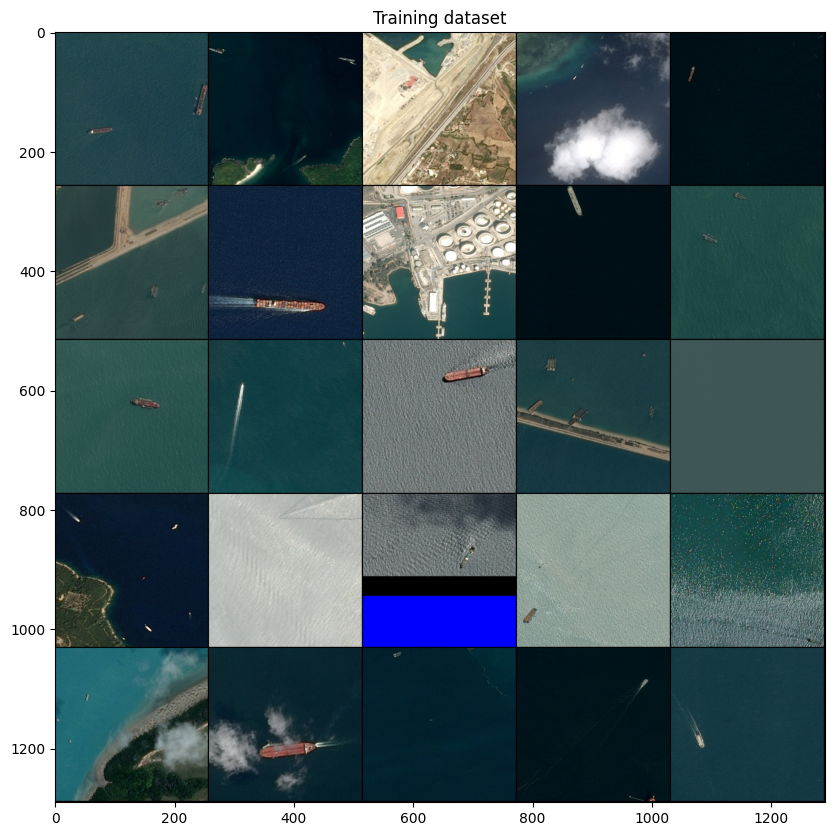

In [67]:
h = 5
w = 5
tile_height = 256 
tile_width = 256 
gap = 2

train_ids_rand = list(train_ids)
random.shuffle(train_ids_rand)


def load_img(filename):
    try:
        img = np.array(PIL.Image.open("input/train/" + filename).resize((tile_height, tile_width)))
        return img
    except:
        print("Error loading image: " + filename)
        return np.zeros((tile_height, tile_width, 3), dtype=np.uint8)

#3 dimensions is RGB
complete_image = np.zeros((h*(tile_height + gap), w*(tile_width + gap), 3), dtype=np.uint8)

#Loading images
img_index = 0
for i in range(h):
    y_start = i*(tile_height + gap)
    y_end = y_start + tile_height
    for j in range(w):
        x_start = j*(tile_width + gap)
        x_end = x_start + tile_width
        if img_index < len(train_ids):
            img = load_img(str(train_ids_rand[img_index]))
            complete_image[y_start:y_end, x_start:x_end, :] = img
            img_index += 1

plt.figure(figsize=(10, 10))
plt.imshow(complete_image)
plt.title("Training dataset")


Text(0.5, 1.0, 'Training dataset with mask overlay')

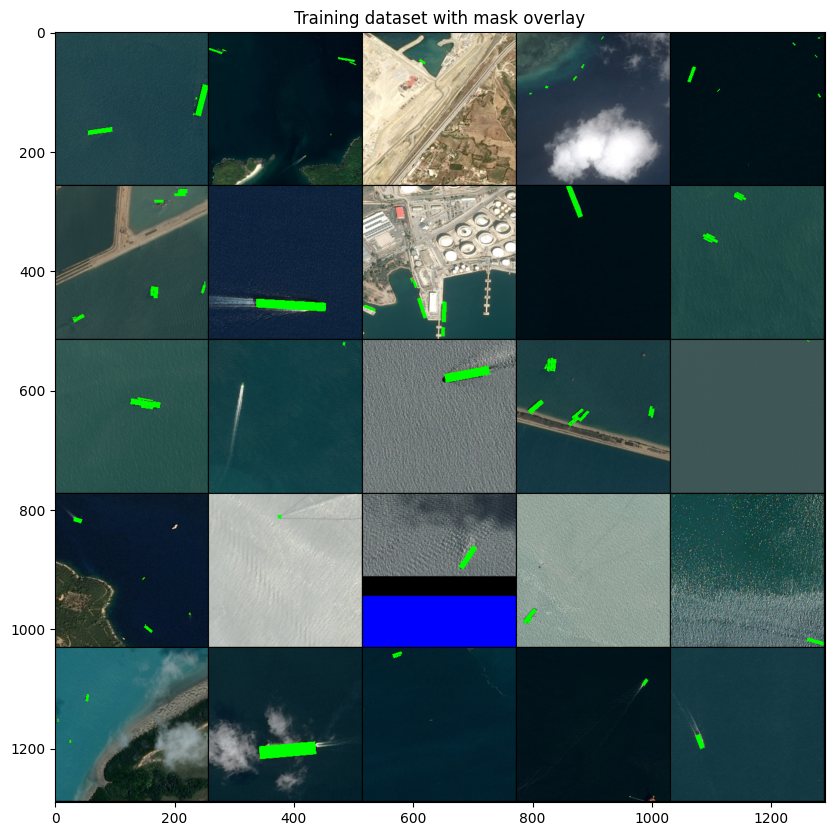

In [68]:
if df_segm.index.name == 'ImageId':
    df_segm = df_segm.reset_index()
if df_segm.index.name != 'ImageId':
    df_segm = df_segm.set_index('ImageId')

def rle_decode(rle_codes, decoded_masks):
    for rle_code in rle_codes:
        rle_code = [int(i) for i in rle_code.split()]
        start_vals = rle_code[0:-1:2]  # Start element:stop element:step
        end_vals = rle_code[1::2]  # No stop element, so it will go to the end

        start_end = list(zip(start_vals, end_vals))

        for start, end in start_end:
            mask_pixels = range(start, start + end)
            mask_coords = [(pixel_pos // 768, pixel_pos % 768) for pixel_pos in mask_pixels]

            for x, y in mask_coords:
                decoded_masks[y, x] = 1 # Set the decoded mask pixel to 1, meaning that it contains ship
    return decoded_masks

def mask_overlay(image, mask):
    mask = (mask * 255).astype('uint8') 

    mask = Image.fromarray(mask)  # Convert the mask to a PIL Image

    mask = mask.convert("L")     # Convert the mask to grayscale in order for it to be applied correctly
    colored_mask = Image.new("RGBA", mask.size, (0, 0, 0, 0))  # Assigning a black color to the mask so it would be invisible

    colored_mask.paste((0, 255, 0, 255), mask=mask) # Apply the mask to the colored mask

    image = Image.fromarray(image) # Convert the image to a PIL Image
    image = image.convert("RGBA")
    image = image.resize(mask.size)  # Resize the image to match the mask size

    # Overlay the colored mask on the image
    img_masked = Image.alpha_composite(image, colored_mask)
    img_masked = img_masked.convert("RGB")  # Convert the image back to RGB
    return np.array(img_masked)
    

img_index = 0
for i in range(h): 
    y_start = i*(tile_height + gap)
    y_end = y_start + tile_height
    for j in range(w):
        x_start = j*(tile_width + gap)
        x_end = x_start + tile_width
        if img_index < len(train_ids):
            decoded_masks = np.zeros((768, 768)) # Emty array of zeros in which the decoded mask will be stored
            img_rle = df_segm.loc[train_ids_rand[img_index], "EncodedPixels"]  # Accessing Encoded pixels of the current image and converting to list in case there are multiple masks
            
            if isinstance(img_rle, str):
                # If it's a string, convert it to a list with a single element
                img_rle = [img_rle]
            else:
                # If it's a series, convert the whole series to a list
                img_rle = img_rle.tolist()
            
            for rle in img_rle:
                rle_decode(img_rle, decoded_masks)

            img = load_img(str(train_ids_rand[img_index]))
            img_masked = mask_overlay(img, decoded_masks)  # Apply the overlay

            img_masked = cv2.resize(img_masked, (tile_height, tile_width))  # Resize the image to the tile size
            complete_image[y_start:y_end, x_start:x_end, :] = img_masked
            img_index += 1

plt.figure(figsize=(10, 10))
plt.imshow(complete_image)
plt.title("Training dataset with mask overlay")

## Analysing distribution

Number of images with ships: 42556
Number of images with no ships: 150000


<BarContainer object of 2 artists>

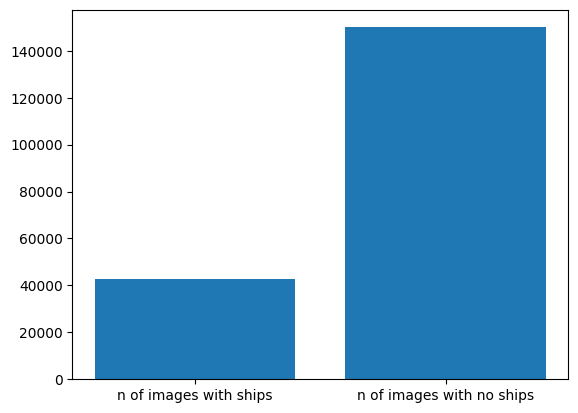

In [69]:
df_segm_an = pd.read_csv("input/train_ship_segmentations_v2.csv")

n_ships = df_segm_an[~df_segm_an.EncodedPixels.isna()].ImageId.unique()
n_noships = df_segm_an[df_segm_an.EncodedPixels.isna()].ImageId.unique()

print("Number of images with ships: " + str(len(n_ships)))
print("Number of images with no ships: " + str(len(n_noships)))


plt.bar(["n of images with ships", "n of images with no ships"], [len(n_ships), len(n_noships)])



## Split into training and validation groups

<Axes: xlabel='ships'>

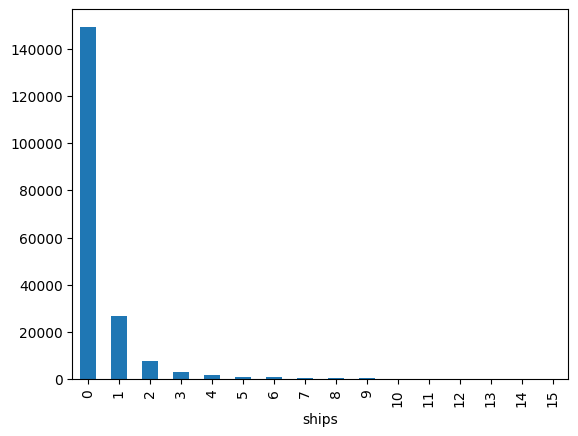

In [70]:
# Check for the presence of the ship on the image, and if it is, assign 1, otherwise 0
ships = []
for row in df_segm_an["EncodedPixels"]:
    if isinstance(row, str):
        ships.append(1)
    else:
        ships.append(0)

df_segm_an["ships"] = ships

# Grouping by ImageId and summing the number of ships in each image
uimg_ids = df_segm_an.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
uimg_ids["EncodedPixels"] = df_segm_an["EncodedPixels"]
uimg_ids.reset_index() 
uimg_ids['has_ship'] = uimg_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)

def get_size_kb(img_id):
    file_path = os.path.join(path_train_str, img_id)  # Get the path to the img

    # Get the size in bytes and convert to kilobytes
    file_size_bytes = os.stat(file_path).st_size
    file_size_kb = file_size_bytes / 1024
    
    return file_size_kb

#Create new column with image size in kb
uimg_ids['file_size_kb'] = uimg_ids['ImageId'].map(get_size_kb)

uimg_ids = uimg_ids[uimg_ids['file_size_kb'] > 50] # keep only +50kb files

uimg_ids['ships'].value_counts().sort_index().plot(kind='bar')


### Balancing the train data
Write why the dataset should be balanced

22696 masks


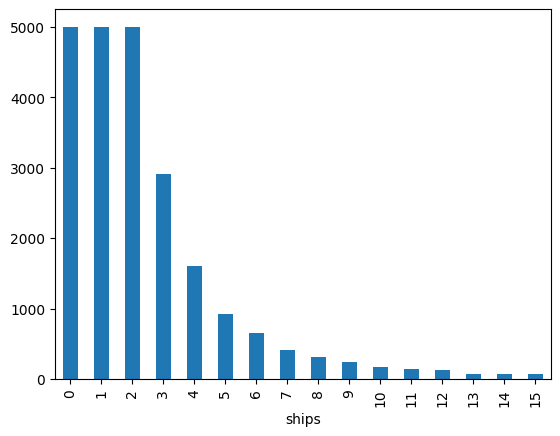

In [71]:
train_ids, valid_ids = train_test_split(uimg_ids, 
                 test_size = 0.2, 
                 stratify = uimg_ids['ships'])

valid_df = pd.merge(df_segm_an, valid_ids)

SAMPLES_PER_GROUP = 5000
balanced_train_df = uimg_ids.groupby('ships').apply(lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x)
balanced_train_df['ships'].value_counts().sort_index().plot(kind='bar')
print(balanced_train_df.shape[0], 'masks')

In [72]:
TRAIN = 'input/train'
TEST = 'input/test/'

# The batch size is a number of samples processed before the model is updated. 
BATCH_SIZE = 4

def masks2image(mask_rle):
    decoded_masks = np.zeros((768, 768), dtype = np.int16)

    if isinstance(mask_rle, str):
        # If it's a string, convert it to a list with a single element
        mask_rle = [mask_rle]

    if not pd.isna(mask_rle):
        rle_decode(mask_rle, decoded_masks)
        
    return np.expand_dims(decoded_masks, -1)

# Convert all RLE into images 
def make_image_gen(in_df, batch_size = BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    out_img = []
    out_mask = []

    while True: #Infinite loop
        np.random.shuffle(all_batches)

        for c_img_id, c_masks in all_batches: #Iterate over batches
            img_path = os.path.join(TRAIN, c_img_id)
            c_img = Image.open(img_path)
            c_mask = masks2image(c_masks['EncodedPixels'].values)
                
            out_img += [c_img]
            out_mask += [c_mask]
            if len(out_img)>=batch_size:
                yield np.stack(out_img, 0)/255.0, np.stack(out_mask, 0) # Return the data (yielding it into a tuple)
                out_img, out_mask=[], []



In [73]:
VALID_IMG_COUNT = 400

train_gen = make_image_gen(balanced_train_df)
train_x, train_y = next(train_gen)
print("train set")
print('x', train_x.shape, train_x.min(), train_x.max()) ## np stacks
print('y', train_y.shape, train_y.min(), train_y.max())

print("validation set")
valid_x, valid_y = next(make_image_gen(valid_df, VALID_IMG_COUNT))
print(valid_x.shape, valid_y.shape)

train set
x (4, 768, 768, 3) 0.0 1.0
y (4, 768, 768, 1) 0 1
validation set
(400, 768, 768, 3) (400, 768, 768, 1)
